In [120]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import r2_score
from yellowbrick.model_selection import feature_importances

import matplotlib.pyplot as plt
%matplotlib inline

In [121]:
import success as scs
import finance as fin
import merge_sets as ms
import utility_functions as uf

---

In [122]:
df = pd.read_pickle('./data/df_yeo.pkl')

In [123]:
X = df.drop(columns='achievement')
y = df['achievement']

In [135]:
cv_scores = uf.kfold_val(X,y)
lasso_scores = uf.lasso_cv(X,y)
ridge_scores = uf.ridge_cv(X,y)

print(f'CV R^2: {cv_scores[0]}, Lasso R^2: {lasso_scores[0]}, Ridge R^2: {ridge_scores[0]}\
        \nLasso MAE: {lasso_scores[1]}, Ridge MAE: {ridge_scores[1]}')

Quantile Transform 
CV R^2: 0.41063634669895255, Lasso R^2: 0.45673522724437343, Ridge R^2: 0.4720592606355478        
Lasso MAE: 0.4345817728352721, Ridge MAE: 0.42430120154453266


---

At this point, I really wanted to focus on decreasing the complexity of my model. However, since a lot of the focus of my project is on understanding the impact of features, I wanted to be very careful not to drop the wrong features. Therefore, I ended up going through and dropping features one at a time, reevaluating, then iterating.

In [162]:
# x_dropped = ['D', 'A', 'A2', 'C', 'tchrs_w_exp', 'K1', 'temp_hous', 'hra','B1', 'A4', 'K6', 'enroll', \
#           'C2', 'J', 'B2','C2', 'hisp','white', 'C1', 'A3', 'iep', 'K3', 'comm_rat',\
#           'tchr_attend', 'B', 'tchrs_rat', 'ldr_rat', 'prncpl_exp', 'K', 'C3','slf_cont', 'K5',\
#            'A_non_iep', 'iep', 'A1', 'asian', 'poc']
x_dropped = ['C', 'J', 'B', 'B1', 'B2', 'C1', 'C2', 'tchrs_w_exp', 'D', 'A3', 'A4', 'K1', 'A2', 'A_non_iep', 'K',\
            'K6', 'white', 'A1', 'C3', 'trust_rat', 'ldr_rat', 'poc', 'tchr_attend', 'K5', 'temp_hous',\
            'hra', 'hisp', 'comm_rat', 'enroll', 'K5', 'prncpl_exp', 'A', 'K3', 'slf_cont', 'K4']

X2 = df.drop(columns=['achievement', *x_dropped])

cv_r2 = uf.kfold_val(X2, y)[0].round(6)
lasso = uf.lasso_cv(X2, y)
ridge = uf.ridge_cv(X2, y)
lasso_r2 = lasso[0].round(6)
ridge_r2 = ridge[0].round(6)
print(f'CV R^2: {cv_r2}, Lasso R^2: {lasso_r2}, Ridge R^2: {ridge_r2}')

model = sm.OLS(y, sm.add_constant(X2))
results = model.fit()
results.summary()

CV R^2: 0.427843, Lasso R^2: 0.420931, Ridge R^2: 0.44051


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            achievement   R-squared:                       0.441
Model:                            OLS   Adj. R-squared:                  0.435
Method:                 Least Squares   F-statistic:                     73.88
Date:                Thu, 16 Jul 2020   Prob (F-statistic):          8.25e-133
Time:                        20:42:58   Log-Likelihood:                -944.08
No. Observations:                1139   AIC:                             1914.
Df Residuals:                    1126   BIC:                             1980.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.4021      0.017    205.962      0.000       3.370       3.435
asian          0.0808      0.024      3.381      0.001       0.034       0.128
black         -0.1130      0.026     -4.355      0.000      -0.164      -0.062
ell           -0.1301      0.028     -4.591      0.000      -0.186      -0.074
iep            0.0879      0.023      3.837      0.000       0.043       0.133
econ_need      0.0995      0.034      2.917      0.004       0.033       0.166
attend         0.8199      0.099      8.270      0.000       0.625       1.014
chron_abs      0.4284      0.092      4.654      0.000       0.248       0.609
overage        0.3180      0.033      9.614      0.000       0.253       0.383
instr_rat      0.2203      0.039      5.703      0.000       0.144       0.296
tchrs_rat     -0.1169      0.031     -3.798      0.000      -0.177      -0.056
env_rat        0.1484      0.035      4.219      0.000       0.079       0.217
K2            -0.1107      0.022     -5.006      0.000      -0.154      -0.067
==============================================================================
Omnibus:                        1.963   Durbin-Watson:                   0.860
Prob(Omnibus):                  0.375   Jarque-Bera (JB):                1.835
Skew:                           0.076   Prob(JB):                        0.400
Kurtosis:                       3.124   Cond. No.                         17.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In order to evaluate the impact a dropping any given feature, I wrote a function to iterate through the remaining columns in the model, and return the change in R^2 that would result from dropping each column. I wanted to see how various models changed as I went through this process, so I evaluated the change in R^2 for a regular linear regression, for a lasso cv, and for a ridge cv (with an optional parameter to only do 1-2 specific models). I then had the function print out the change in R^2 for a given column, based on whether on not the mean change in R^2 from all the models I was looking at was above a certain threshold (which varied throughout the process).

Additionally, I wanted to be sure that dropping a column would not subsequently increase the impact of a previously dropped column, so I also wrote a function to loop through the previously dropped columns, and evaluate the change in R^2 for each model that would result from adding that column back into the model.

In [153]:
uf.drop_infl(X2, y, cv_r2, lasso_r2, ridge_r2, threshold = -0.005, models=['cv','ridge'])
uf.add_infl(df, y, cv_r2, lasso_r2, ridge_r2, x_dropped, threshold = 0.002, models=['cv','ridge'])

12
Drop asian -> CV: -0.006248, L: , R: -0.00568, mean: -0.005964
Drop black -> CV: -0.008882, L: , R: -0.009423, mean: -0.009153
Drop ell -> CV: -0.008576, L: , R: -0.010471, mean: -0.009524
Drop iep -> CV: -0.006857, L: , R: -0.007314, mean: -0.007086
Drop econ_need -> CV: -0.001887, L: , R: -0.004227, mean: -0.003057
Drop tchrs_rat -> CV: -0.007049, L: , R: -0.007166, mean: -0.007107
Drop env_rat -> CV: -0.00693, L: , R: -0.008846, mean: -0.007888
Add prncpl_exp -> CV: 0.001693, L: , R: 0.00305, mean: 0.002372
Add K3 -> CV: 0.002415, L: , R: 0.003084, mean: 0.00275
Add K4 -> CV: 0.002291, L: , R: 0.003725, mean: 0.003008


I also used the below plots as an additional metric for determining feature importance.

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


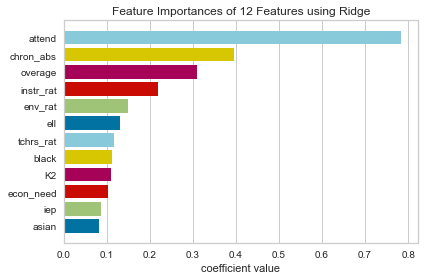

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


FeatureImportances(absolute=True,
                   ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f9f411d46d0>,
                   is_fitted=False, model=None, relative=False)

In [163]:
feature_importances(RidgeCV(), X2, y, is_fitted=False, relative=False, absolute=True)

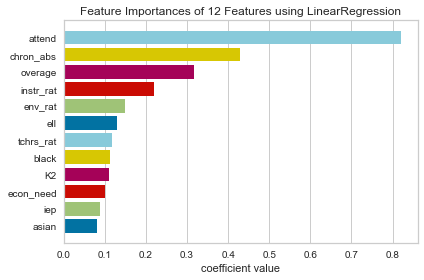

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


FeatureImportances(absolute=True,
                   ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f9f42161f90>,
                   model=None, relative=False)

In [151]:
feature_importances(LinearRegression(), X2, y, relative=False, absolute=True)

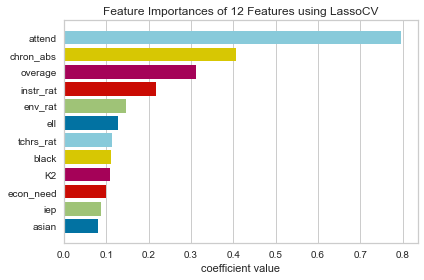

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


FeatureImportances(absolute=True,
                   ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f9f43db3150>,
                   model=None, relative=False)

In [165]:
feature_importances(LassoCV(), X2, y, relative=False, absolute=True)

During this iteration process, I noticed a few interesting things. When I began, with 40 odd columns, the ridge regularization gave me the best R^2, followed by the lasso regularization, then the regular model. However, as I removed columns, the plain linear regression began to improve, while the lasso and ridge regularizations began to worsen, the lasso at a faster rate than the ridge. By the time I made it down to ~25 columns, the plain linear regression was doing better than the lasso, although the ridge still outperformed both. After that point, the plain regression began to worsen again. By the time I got down to 12 features, the ridge remained the best performing model, so that's what I ended up going with as my model of choice.

---

Heat map of my remaining 12 features. 
 *Note: Although chronic absences are highly correlted with attendance, my model suffers when I try to take either of them out. Similar issues arise with instr_rat (rigorous instruction), tchrs_rat (collaborative teachers), and env_rat (supportive environment).*

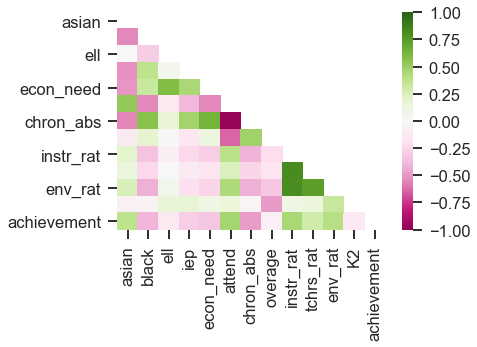

In [155]:
df_heat = df.drop(columns=x_dropped).corr()
mask = np.zeros_like(df_heat)
mask[np.triu_indices_from(mask)] = True
s = sns.plotting_context(context='talk')
with sns.plotting_context(s):
    sns.heatmap(df_heat, mask=mask,cmap='PiYG', vmin=-1, vmax=1)

---

Final model:

In [189]:
alphavec = 10**np.linspace(-2,2,200)
model = RidgeCV(alphas = alphavec, cv=5)
model.fit(X, y)
coeffs = list(zip(X.columns, model.coef_))

In [190]:
coeffs

[('enroll', -0.032260002020403904),
 ('asian', 0.10859254420646103),
 ('black', -0.11576849049041539),
 ('hisp', -0.04363510378314555),
 ('white', 0.008844140239977557),
 ('ell', -0.12147652321329608),
 ('iep', 0.18496171812820544),
 ('slf_cont', -0.05156742451522391),
 ('econ_need', 0.3408276725159383),
 ('temp_hous', -0.052457278073877574),
 ('hra', -0.20056267339294867),
 ('attend', 0.6990184171360846),
 ('chron_abs', 0.36528406214225506),
 ('overage', 0.22481968780155506),
 ('prncpl_exp', 0.04255405526194966),
 ('tchrs_w_exp', 0.001573581167650951),
 ('tchr_attend', 0.03098019990601746),
 ('instr_rat', 0.18250003341728838),
 ('tchrs_rat', -0.15369998933076265),
 ('env_rat', 0.1783357964990138),
 ('ldr_rat', 0.10091708542183254),
 ('comm_rat', -0.038323765552245655),
 ('trust_rat', -0.05850535140837964),
 ('A', -0.06796477494499932),
 ('B', 0.016674622004120555),
 ('C', 0.009308014593086545),
 ('A1', 0.06752198961214025),
 ('A2', 0.0254973185721701),
 ('A3', -0.04793551395021215),
 

***

Ok so I thought I had a deent model, but either I did something wrong or my model just sucks ass


Imma fix this l8r

In [191]:
df_test = pd.read_pickle('./data/df_yeo_test.pkl')
X_test = df_test.drop(columns=['achievement'])#, *x_dropped])
y_test = df_test['achievement']

In [192]:
test_pred = model.predict(X_test)
r2 = r2_score(y_test, test_pred)
mae = uf.calc_mae(y_test, test_pred)
print(f'Test data scores: r^2 - {r2}, mae - {mae}')

Test data scores: r^2 - -0.6365344137611886, mae - 0.7547280077565025
